In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from collections import defaultdict, Counter


from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_val_predict

from sklearn.decomposition import SparsePCA 

import joblib 

In [2]:
# function to estimate corrs 
def estimate_corrs(y_original, y_inferred, labels, corr_type):
    """
    corr_type è un parametro che specifica se la correlazione deve essere 
    calcolata tra le righe ("byrow") o tra le colonne ("bycolumn") delle due
    matrici fornite in input
    
    In out fornisce sia la correlazione media che un Counter con le correlazioni puntuali
    """
    corrs = Counter()
        
    if corr_type == "byrow":
        for i in range(len(y_original)):
            rho, _ = spearmanr(y_original[i], y_inferred[i])
            corrs[labels[i]] = rho
        
    elif corr_type == "bycolumn":
        for i in range(y_original.shape[1]):
            rho, _ = spearmanr(y_original[:,i], y_inferred[:,i])
            corrs[labels[i]] = rho
                
    average_rho = np.average(list(corrs.values()))
        
    return corrs, average_rho

#helper function to load the embeddings and reshape them along with the sspace
def embeddings_preparation(model_emb_path, sspace_nsubj , sspace_dobj, model_name = "", return_new_sspace = False):
    
    """Parameters:
    model_emb_path: name under wich embeddings are saved
    sspace_nsubj: the sspace loaded for the nsubj
    sspace_dobj: the sspace loaded for the dobj
    model_name: the name of the model we are referringe to. Will be used to store the spaces with the right key.
    return_new_sspace: parameter to decide if we want in output the reshaped sspaces. To be used the first time only.
    
    Output:
    a dictionary containing two keys with respective values: the actual embedding space and a baseline with the same shape
    new_sspace_nsubj, new_sspace_dobj: the reshaped target semantic spaces (only if param return_new_sspace =True)
    """
    
    #load the embeddings for the given model
    dir_path = "..\\Data\\Extracted_Embeddings"
    with open(os.path.join(dir_path,model_emb_path), "rb") as infile:
        embeddings_dict = pickle.load(infile)
    
    #convert the dictionary into a dataframe
    emb_df = pd.DataFrame(embeddings_dict).T 
    
    #take the index of the semantic spaces to match the extracted verbs
    verbs2keep_nsubj = sspace_nsubj.index.tolist()
    verbs2keep_dobj = sspace_dobj.index.tolist()
    
    #filter the verbs from the target semantic space to match the embeddings spaces
    model_nsubj = emb_df.filter(items = verbs2keep_nsubj, axis = 0).apply(lambda x:(x-x.min())/(x.max()-x.min()))
    model_dobj = emb_df.filter(items = verbs2keep_dobj, axis = 0 ).apply(lambda x:(x-x.min())/(x.max()-x.min()))

    #reverse the process to restrict the semantic spaces
    sspace_nsubj_final = sspace_nsubj.filter(model_nsubj.index.tolist(), axis = 0)
    sspace_dobbj_final = sspace_dobj.filter(model_dobj.index.tolist(), axis = 0)
    
    #store all the spaces along with a baseline in a dictionary
    spaces_dict_nsubj = {}
    spaces_dict_nsubj[model_name+"_nsubj"] = model_nsubj.values 
    spaces_dict_nsubj[model_name+"_nsubj_baseline"] = np.random.random_sample(model_nsubj.shape)
    
    # same for dobj
    spaces_dict_dobj = {}
    spaces_dict_dobj[model_name+"_dobj"] = model_dobj.values 
    spaces_dict_dobj[model_name+"_dobj_baseline"] = np.random.random_sample(model_dobj.shape)
    
    if return_new_sspace:
        return spaces_dict_nsubj, spaces_dict_dobj, sspace_nsubj_final, sspace_dobbj_final
    else:
        return spaces_dict_nsubj, spaces_dict_dobj


#helper function to automate correlations estimation
def get_correlations_values(model_space:dict, semantic_space: pd.DataFrame, sPca = True):
    
    """Parameters:
    model_space: a dictionary containig 2 keys: the actual model embedding space for the gram argument(e.g. nsubj)
                 and the random baseline shape as the model space.
    semantic_space: a data frame the target semantic space for the referred gram argument. Will be used as y and to derive labels
                    for corrs estimation.
    sPCA: a boolean to decide if we want to transform the target space with sPCA. Default to True to reduce noise.
    
    Output:
    Print average rhos values, by column and by row, for the embedding space and the baseline
    all_corrs: puncutal correlations by row and column for model and baseline.
    all_avg_rhos: average rhos by row and column, for model and baseline."""
    
    # initialize the regressor and dictionary to be filled
    pls = PLSRegression(n_components= 10)
    all_corr = defaultdict(dict)
    all_avg_rhos = defaultdict(dict)
    y_pred = {}
    #get the verbs and properties names, to be used as labels in corr estimation
    verbs = semantic_space.index.tolist()
    properties = semantic_space.columns.tolist()
    
    #initialize the sPCA and transform the target space if param not False
    if sPca:
        print(f"Sparse PCA activated\n")
        pca = SparsePCA(n_components=14)
        y = pca.fit_transform(semantic_space.values)
    else:
        print(f"Not using Sparse PCA")
        y = semantic_space.values
        
    # mapping for the given space
    for k in model_space.keys():
        X = model_space[k]
        y = y
        #get prediction values with cross validation k=10
        y_pred[k] = cross_val_predict(pls, X, y, cv = 10)

        # store and print correlation by row    
        corrs, avg_rho = estimate_corrs(y,y_pred[k], verbs, 'byrow')
        print(f"Average row correlation for the {k} space: {avg_rho}")

        all_corr[k]['byrow'] = corrs
        all_avg_rhos[k]['byrow'] = avg_rho

        # store and print correlation by column
        corrs, avg_rho = estimate_corrs(y,y_pred[k], properties, 'bycolumn')
        print(f"Average column correlation for the {k} space: {avg_rho}\n")

        all_corr[k]['bycolumn'] = corrs
        all_avg_rhos[k]['bycolumn'] = avg_rho

    return all_corr, all_avg_rhos 

In [3]:
#helper function to aggregate all correlation results in a unique dataframe
def aggregate_results(list_of_dict, save_results = False, file_name = "", output_path = ""):
    outdir = output_path
    df = pd.concat([pd.DataFrame(i).T for i in list_of_dict])
    
    if save_results:
        file_name = file_name+".csv"
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        df.to_csv(os.path.join(outdir,file_name), sep = "\t")
        
        return df
    else:
        return df

In [42]:
##to extract sorted values for properties prediction for each model
get_most_comm = lambda x: x[list(x.keys())[0]]["bycolumn"].most_common()

In [4]:
np.random.seed(42)

In [5]:
#upload the semantic spaces for both arguments
sspace_nsubj = pd.read_csv("..\\Data\\Semantic_Spaces\\sspace_spr2_nsubj.csv", index_col = 'Token.Sent')
sspace_dobj = pd.read_csv("..\\Data\\Semantic_Spaces\\sspace_spr2_dobj.csv",  index_col = 'Token.Sent')

## Mapping BabyBERTa

In [6]:
#baby BERTa
model_emb_path = "target_embeddings_BabyBERTa-2.pkl"
bb_dict_nsubj, bb_dict_dobj, final_sspace_nsubj, final_sspace_dobj = embeddings_preparation(model_emb_path, 
                                                                    sspace_nsubj,
                                                                    sspace_dobj, 
                                                                    model_name = "BabyBERTa",
                                                                    return_new_sspace= True)

bb_corrs_nsubj, bb_avgr_nsubj = get_correlations_values(bb_dict_nsubj, final_sspace_nsubj)
bb_corrs_dobj, bb_avgr_dobj = get_correlations_values(bb_dict_dobj, final_sspace_dobj)

#aggregate_results([bb_avgr_nsubj,bb_avgr_dobj], save_results = True, file_name = babyBERTa_avgr)

Sparse PCA activated

Average row correlation for the BabyBERTa_nsubj space: 0.3454790023254753
Average column correlation for the BabyBERTa_nsubj space: 0.3570435498045595

Average row correlation for the BabyBERTa_nsubj_baseline space: -0.026640372076056726
Average column correlation for the BabyBERTa_nsubj_baseline space: -0.03443351206489502

Sparse PCA activated

Average row correlation for the BabyBERTa_dobj space: 0.1994090416625628
Average column correlation for the BabyBERTa_dobj space: 0.20121971805471586

Average row correlation for the BabyBERTa_dobj_baseline space: -0.04497192947897173
Average column correlation for the BabyBERTa_dobj_baseline space: -0.04283471976351089



In [39]:
# no sPCA
bb_corrs_nsubj, bb_avgr_nsubj = get_correlations_values(bb_dict_nsubj, final_sspace_nsubj,sPca = False)
bb_corrs_dobj, bb_avgr_dobj = get_correlations_values(bb_dict_dobj, final_sspace_dobj, sPca = False)

Not using Sparse PCA
Average row correlation for the BabyBERTa_nsubj space: 0.7710238419553743
Average column correlation for the BabyBERTa_nsubj space: 0.3570464734001003

Average row correlation for the BabyBERTa_nsubj_baseline space: 0.7079004224299861
Average column correlation for the BabyBERTa_nsubj_baseline space: -0.018589531823358273

Not using Sparse PCA
Average row correlation for the BabyBERTa_dobj space: 0.6575879560911262
Average column correlation for the BabyBERTa_dobj space: 0.20120690436413316

Average row correlation for the BabyBERTa_dobj_baseline space: 0.5645505268416493
Average column correlation for the BabyBERTa_dobj_baseline space: -0.03241292901561521



## Mapping Pythia

In [43]:
#Pythia
model_emb_path = "target_embeddings_pythia-70m-deduped.pkl"
pythia_dict_nsubj, pythia_dict_dobj= embeddings_preparation(model_emb_path, 
                                                    sspace_nsubj,
                                                    sspace_dobj, 
                                                    model_name = "Pythia70m"
                                                    )

pythia_corrs_nsubj, pythia_avgr_nsubj = get_correlations_values(pythia_dict_nsubj, final_sspace_nsubj)
pythia_corrs_dobj, pythia_avgr_dobj = get_correlations_values(pythia_dict_dobj, final_sspace_dobj)

#aggregate_results([pythia_avgr_nsubj,pythia_avgr_dobj], save_results = True, file_name = Pythia70m_avgr)

Sparse PCA activated

Average row correlation for the Pythia70m_nsubj space: 0.40719985408782094
Average column correlation for the Pythia70m_nsubj space: 0.3987736007744081

Average row correlation for the Pythia70m_nsubj_baseline space: 0.009269983128904292
Average column correlation for the Pythia70m_nsubj_baseline space: -0.0025355962872302133

Sparse PCA activated

Average row correlation for the Pythia70m_dobj space: 0.21492591915127127
Average column correlation for the Pythia70m_dobj space: 0.21103843645134115

Average row correlation for the Pythia70m_dobj_baseline space: -0.03973209888702846
Average column correlation for the Pythia70m_dobj_baseline space: -0.04758999916496879



In [42]:
pythia_corrs_nsubj, pythia_avgr_nsubj = get_correlations_values(pythia_dict_nsubj, final_sspace_nsubj, sPca = False)
pythia_corrs_dobj, pythia_avgr_dobj = get_correlations_values(pythia_dict_dobj, final_sspace_dobj,sPca = False)

Not using Sparse PCA
Average row correlation for the Pythia70m_nsubj space: 0.7816389431104404
Average column correlation for the Pythia70m_nsubj space: 0.39878595139884104

Average row correlation for the Pythia70m_nsubj_baseline space: 0.6869785933114928
Average column correlation for the Pythia70m_nsubj_baseline space: -0.016999105149870172

Not using Sparse PCA
Average row correlation for the Pythia70m_dobj space: 0.6682005261153099
Average column correlation for the Pythia70m_dobj space: 0.21107765574626722

Average row correlation for the Pythia70m_dobj_baseline space: 0.5479877990161518
Average column correlation for the Pythia70m_dobj_baseline space: -0.008249606870172932



## Mapping GPT2-XL

In [44]:
#GPT2-XL
model_emb_path = "target_embeddings_gpt2-xl.pkl"
gpt2xl_dict_nsubj, gpt2xl_dict_dobj= embeddings_preparation(model_emb_path, 
                                                    sspace_nsubj,
                                                    sspace_dobj, 
                                                    model_name = "GPT2-XL"
                                                    )

gpt2xl_corrs_nsubj, gpt2xl_avgr_nsubj = get_correlations_values(gpt2xl_dict_nsubj, final_sspace_nsubj)
gpt2xl_corrs_dobj, gpt2xl_avgr_dobj = get_correlations_values(gpt2xl_dict_dobj, final_sspace_dobj)

#aggregate_results([gpt2xl_avgr_nsubj,gpt2xl_avgr_dobj], save_results = True, file_name = GPT2-XL_avgr)

Sparse PCA activated

Average row correlation for the GPT2-XL_nsubj space: 0.4234804614472664
Average column correlation for the GPT2-XL_nsubj space: 0.4076927006612456

Average row correlation for the GPT2-XL_nsubj_baseline space: 0.021417172039578675
Average column correlation for the GPT2-XL_nsubj_baseline space: 0.02705330357746564

Sparse PCA activated

Average row correlation for the GPT2-XL_dobj space: 0.2559327995947714
Average column correlation for the GPT2-XL_dobj space: 0.26106065176527615

Average row correlation for the GPT2-XL_dobj_baseline space: 0.007690900648647128
Average column correlation for the GPT2-XL_dobj_baseline space: 0.021374270116589125



In [40]:
gpt2xl_corrs_nsubj, gpt2xl_avgr_nsubj = get_correlations_values(gpt2xl_dict_nsubj, final_sspace_nsubj, sPca = False)
gpt2xl_corrs_dobj, gpt2xl_avgr_dobj = get_correlations_values(gpt2xl_dict_dobj, final_sspace_dobj, sPca = False)

Not using Sparse PCA
Average row correlation for the GPT2-XL_nsubj space: 0.7870254165356915
Average column correlation for the GPT2-XL_nsubj space: 0.4077370644255654

Average row correlation for the GPT2-XL_nsubj_baseline space: 0.6539906945969608
Average column correlation for the GPT2-XL_nsubj_baseline space: -0.0008460060457187347

Not using Sparse PCA
Average row correlation for the GPT2-XL_dobj space: 0.6824411759289376
Average column correlation for the GPT2-XL_dobj space: 0.26109680628558146

Average row correlation for the GPT2-XL_dobj_baseline space: 0.5649349274801263
Average column correlation for the GPT2-XL_dobj_baseline space: -0.020835481530775905



## DistilBERT

In [13]:
#DistilBERT
model_emb_path = "target_embeddings_distilbert-base-uncased.pkl"
db_dict_nsubj, db_dict_dobj  = embeddings_preparation(model_emb_path,
                                                                    sspace_nsubj,
                                                                    sspace_dobj,
                                                                    model_name = "DistilBERT",
                                                                    return_new_sspace= False)

db_corrs_nsubj, db_avgr_nsubj = get_correlations_values(db_dict_nsubj, final_sspace_nsubj)
db_corrs_dobj, db_avgr_dobj = get_correlations_values(db_dict_dobj, final_sspace_dobj)

Sparse PCA activated

Average row correlation for the DistilBERT_nsubj space: 0.46428115453011726
Average column correlation for the DistilBERT_nsubj space: 0.4367163094331722

Average row correlation for the DistilBERT_nsubj_baseline space: -0.011114404267931243
Average column correlation for the DistilBERT_nsubj_baseline space: -0.02180144736941289

Sparse PCA activated

Average row correlation for the DistilBERT_dobj space: 0.38448593659861263
Average column correlation for the DistilBERT_dobj space: 0.37952729591298157

Average row correlation for the DistilBERT_dobj_baseline space: -0.041595024693616235
Average column correlation for the DistilBERT_dobj_baseline space: -0.05069553177017758



In [ ]:
db_corrs_nsubj, db_avgr_nsubj = get_correlations_values(db_dict_nsubj, final_sspace_nsubj,sPca = False)
db_corrs_dobj, db_avgr_dobj = get_correlations_values(db_dict_dobj, final_sspace_dobj, sPca = False)

## Results Aggregation

In [47]:
#aggregate all the results in a unique df
all_avgr_spca = aggregate_results([db_avgr_nsubj,db_avgr_dobj,
                                    pythia_avgr_nsubj,pythia_avgr_dobj,
                                    gpt2xl_avgr_nsubj, gpt2xl_avgr_dobj], 
                                    save_results= True, 
                                    file_name = "all_avgr",
                                    output_path="..\\Data\\Correlations")

In [48]:
all_avgr_spca= all_avgr_spca.round(decimals = 2)

In [49]:
all_avgr_spca

,byrow,bycolumn
DistilBERT_nsubj,0.46,0.44
DistilBERT_nsubj_baseline,-0.01,-0.02
DistilBERT_dobj,0.38,0.38
DistilBERT_dobj_baseline,-0.04,-0.05
Pythia70m_nsubj,0.41,0.40
Pythia70m_nsubj_baseline,0.01,-0.00
Pythia70m_dobj,0.21,0.21
Pythia70m_dobj_baseline,-0.04,-0.05
GPT2-XL_nsubj,0.42,0.41
GPT2-XL_nsubj_baseline,0.02,0.03


In [50]:
# all_avgr_spca.to_latex("..\\Data\\Correlations\\all_avg_rhos.tex", float_format={"%.2f"})

In [65]:
#save all the properties correlations separately
all_models_corrs = [db_corrs_nsubj,db_corrs_dobj,pythia_corrs_nsubj,pythia_corrs_dobj, gpt2xl_corrs_nsubj,gpt2xl_corrs_dobj]
get_properties = lambda x: x[list(x.keys())[0]]["bycolumn"]
get_model_names = lambda x: list(x.keys())[0]
ouput_dir = "..\\Data\\Correlations\\Properties_corrs"
if not os.path.exists(ouput_dir):
    os.mkdir(ouput_dir)
for i in all_models_corrs:
    name = get_model_names(i)
    properties = get_properties(i)
    with open(os.path.join(ouput_dir,name+".pkl"), "wb") as outfile:
        pickle.dump(properties, outfile)

In [84]:
#create a df to have all results aggregated
index = [get_model_names(i) for i in all_models_corrs]
df = pd.concat([pd.DataFrame(get_properties(i), index = [i for i in range(15)]).drop_duplicates() for i in all_models_corrs])
df.index = index
df = df.round(2)
df.to_csv("..\\Data\\Correlations\\Properties_corrs\\all_models_corrs.csv", index_label=  "Model_arg")

In [114]:
df

,awareness,change_of_location,change_of_possession,change_of_state,change_of_state_continuous,existed_after,existed_before,existed_during,instigation,partitive,sentient,volition,was_for_benefit,was_used
DistilBERT_nsubj,0.70,0.30,0.22,0.18,0.54,0.42,0.46,0.48,0.22,0.69,0.59,0.26,0.72,0.32
DistilBERT_dobj,0.58,0.32,0.59,0.13,0.38,0.24,0.37,0.23,0.45,0.48,0.47,0.21,0.58,0.28
Pythia70m_nsubj,0.65,0.18,0.23,0.13,0.47,0.38,0.42,0.47,0.22,0.67,0.57,0.17,0.69,0.31
Pythia70m_dobj,0.20,0.29,0.45,0.03,0.26,0.15,0.19,0.11,0.36,0.17,0.21,0.07,0.24,0.25
GPT2-XL_nsubj,0.66,0.22,0.24,0.13,0.49,0.38,0.44,0.46,0.24,0.69,0.59,0.19,0.69,0.32
GPT2-XL_dobj,0.28,0.30,0.49,0.15,0.25,0.17,0.21,0.18,0.40,0.23,0.23,0.18,0.31,0.26


In [134]:
for i in np.argmin(df.values, axis = 1):
    print(df.columns[i])


change_of_state
change_of_state
change_of_state
change_of_state
change_of_state
change_of_state


In [136]:
df["was_used"]

DistilBERT_nsubj    0.32
DistilBERT_dobj     0.28
Pythia70m_nsubj     0.31
Pythia70m_dobj      0.25
GPT2-XL_nsubj       0.32
GPT2-XL_dobj        0.26
Name: was_used, dtype: float64

In [135]:
for i in np.argmin(df.values, axis = 0):
    print(df.index[i])

Pythia70m_dobj
Pythia70m_nsubj
DistilBERT_nsubj
Pythia70m_dobj
GPT2-XL_dobj
Pythia70m_dobj
Pythia70m_dobj
Pythia70m_dobj
DistilBERT_nsubj
Pythia70m_dobj
Pythia70m_dobj
Pythia70m_dobj
Pythia70m_dobj
Pythia70m_dobj


In [107]:
pickle.load(open(os.path.join(ouput_dir,"DistilBERT_dobj.pkl"), "rb"))

Counter({'change_of_possession': 0.5859278830147343,
         'awareness': 0.5832453587455781,
         'was_for_benefit': 0.5821067807722763,
         'partitive': 0.4837607536050305,
         'sentient': 0.46734941439108474,
         'instigation': 0.44934060719502295,
         'change_of_state_continuous': 0.3838055282712607,
         'existed_before': 0.3706217592569456,
         'change_of_location': 0.3193797322684799,
         'was_used': 0.279709418056011,
         'existed_after': 0.23823146550656468,
         'existed_during': 0.23383082673385713,
         'volition': 0.20621785623458974,
         'change_of_state': 0.12985475873030575})

In [110]:
df.T.to_latex("..\\Data\\Correlations\\Properties_corrs\\all_models_T.tex", float_format="%.2f")

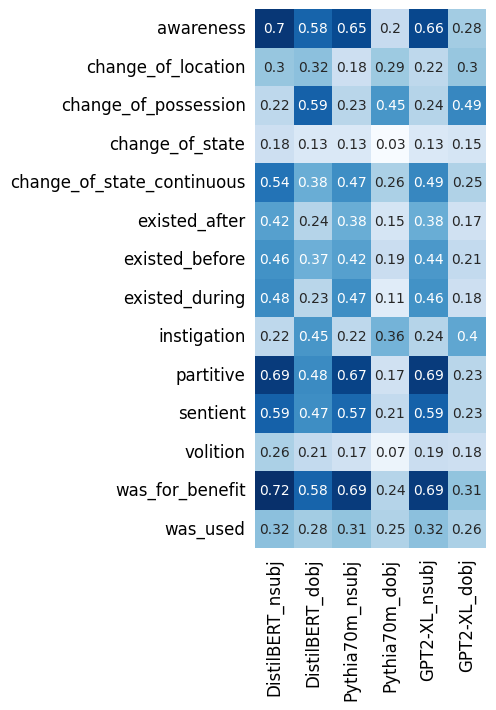

In [111]:
import seaborn as sns
# plot of properties means comparison
plt.figure(figsize= (9,7))

ax = sns.heatmap(df.T, cmap = 'Blues', square= True,
                 cbar = False, annot = True
                )

# remove ticks and set position and orientation for ticks label
ax.tick_params(labeltop = False, labelbottom = True,
                labelsize = 12, bottom = False, left = False)


In [86]:
# df.to_latex("..\\Data\\Correlations\\Properties_corrs\\all_models_corrs.tex",float_format={"%.2f"})